In [17]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
import logging
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Scikit-learn Imports ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Model Imports ---
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import mlflow

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

mlflow_tracking_uri = 'http://localhost:5555'  

In [19]:
# =============================================================================
# 1. MLFLOW CONFIGURATION
# =============================================================================
# Set this to True to enable MLflow tracking, or False to disable it.
ENABLE_MLFLOW_TRACKING = True

if ENABLE_MLFLOW_TRACKING:
    # This will create an 'mlruns' directory in your current folder to store experiments
    mlflow.set_tracking_uri("http://localhost:5555")
    mlflow.set_experiment("Delhi House Rent Prediction")
    print(f"✅ MLflow tracking is ENABLED. URI: '{mlflow.get_tracking_uri()}'")
else:
    print("❌ MLflow tracking is DISABLED.")

# Use nullcontext if tracking is disabled, otherwise use mlflow.start_run
run_context = mlflow.start_run if ENABLE_MLFLOW_TRACKING else nullcontext

✅ MLflow tracking is ENABLED. URI: 'http://localhost:5555'


In [20]:
df = pd.read_csv("../data/processed/featured_house_data.csv")
df.head()

,size_sq_ft,location_avg_price,price_per_sqft,localityName,propertyType,bedrooms,price
0,-0.435155,-0.731866,-0.374931,149.0,0.0,2.0,20000
1,0.961775,-0.265405,-0.732697,131.0,1.0,2.0,28000
2,-0.085922,-0.520067,-0.283196,45.0,1.0,2.0,28000
3,-1.133619,-0.974537,0.098076,62.0,0.0,2.0,12500
4,-0.959003,-0.974537,-0.503933,62.0,2.0,2.0,10000


In [21]:
# Load dataset
data_path = '../data/processed/featured_house_data.csv'  # Update path if needed
data = pd.read_csv(data_path)
X = data.drop('price', axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# =============================================================================
# 3. DEFINE AND TRAIN BASELINE MODELS WITH MLFLOW TRACKING
# =============================================================================
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'KNN': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

results = {}

print("\n" + "="*60)
print("STARTING MODEL TRAINING WITH MLFLOW TRACKING")
print("="*60)

# Start a parent run for the overall comparison
with run_context(run_name="Model Comparison Run") as parent_run:
    for name, model in models.items():
        # Start a nested run for each specific model
        with run_context(run_name=name, nested=True) as child_run:
            print(f"⚙️  Training {name}...")
            
            # Train the model
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            # Calculate metrics
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)
            
            # Store results in the dictionary
            results[name] = {'mae': mae, 'rmse': rmse, 'r2': r2, 'model': model}
            print(f"✅ {name} -> R²: {r2:.4f}, RMSE: {rmse:.2f}\n")
            
            # --- MLflow Logging ---
            if ENABLE_MLFLOW_TRACKING:
                mlflow.log_param("model_name", name)  
                mlflow.log_params(model.get_params())
                mlflow.log_metrics({'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2})
                mlflow.sklearn.log_model(model, artifact_path=name.lower().replace(" ", "_"))
                print(f"   Logged to MLflow run: {child_run.info.run_id}")



STARTING MODEL TRAINING WITH MLFLOW TRACKING
⚙️  Training Linear Regression...
✅ Linear Regression -> R²: 0.6385, RMSE: 31185.84

   Logged to MLflow run: b5383145b1fc4373b037514b3881fd17
⚙️  Training Lasso...
✅ Lasso -> R²: 0.6385, RMSE: 31183.97

   Logged to MLflow run: 83c93b8c7d08450a8cdb451a101c7736
⚙️  Training Ridge...
✅ Ridge -> R²: 0.6386, RMSE: 31180.20

   Logged to MLflow run: c29f7711bad243cb9cab7c723ea2a011
⚙️  Training KNN...
✅ KNN -> R²: 0.8871, RMSE: 17427.20

   Logged to MLflow run: 92aebaab33494c54aa2bdf160aa305fa
⚙️  Training Decision Tree...
✅ Decision Tree -> R²: 0.9321, RMSE: 13516.85

   Logged to MLflow run: d9dae30c606f4abd804977b2d462abed
⚙️  Training Random Forest...
✅ Random Forest -> R²: 0.9410, RMSE: 12603.63

   Logged to MLflow run: 208dd404bd9c42c4bc974a652ff8f987
⚙️  Training XGBoost...
✅ XGBoost -> R²: 0.9843, RMSE: 6499.78

   Logged to MLflow run: 2cd82dc107ea447c825efe5f24945887
⚙️  Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise 

In [23]:
# Find the best model based on the R² score
best_model_name = max(results, key=lambda name: results[name]['r2'])
best_model_details = results[best_model_name]
best_model_object = best_model_details['model']

print("="*60)
print("TRAINING COMPLETE - RESULTS SUMMARY")
print("="*60)
print(f"🏆 Best Performing Model: {best_model_name}")
print(f"   - R² Score: {best_model_details['r2']:.4f}")
print(f"   - RMSE:     {best_model_details['rmse']:.2f}")
print(f"   - MAE:      {best_model_details['mae']:.2f}")

TRAINING COMPLETE - RESULTS SUMMARY
🏆 Best Performing Model: Gradient Boosting
   - R² Score: 0.9863
   - RMSE:     6065.57
   - MAE:      1749.44



Generating performance comparison plots...


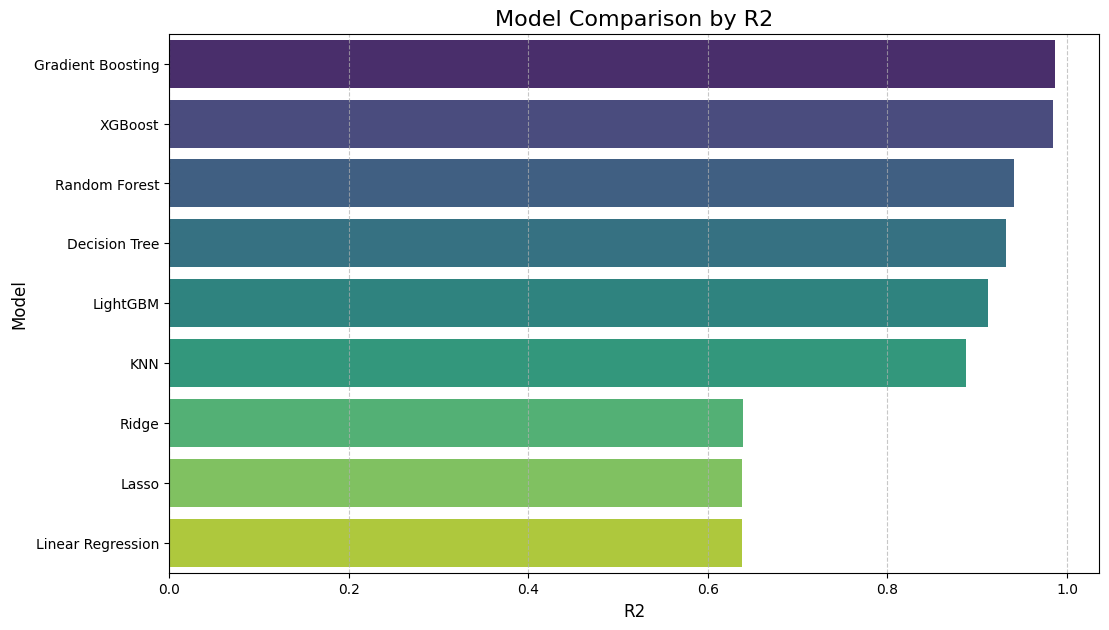

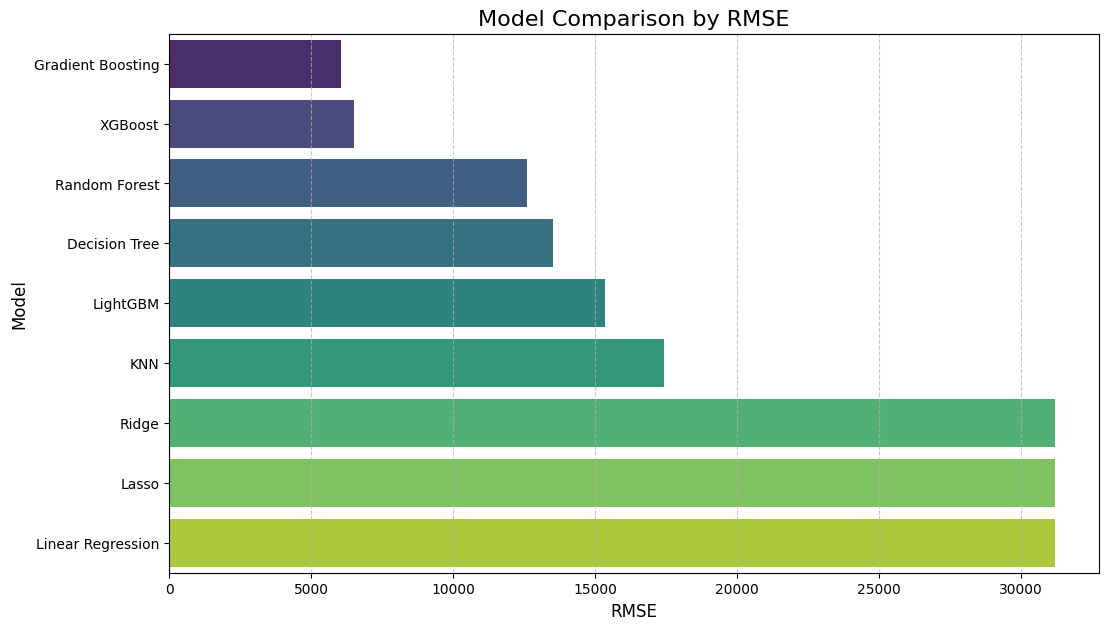

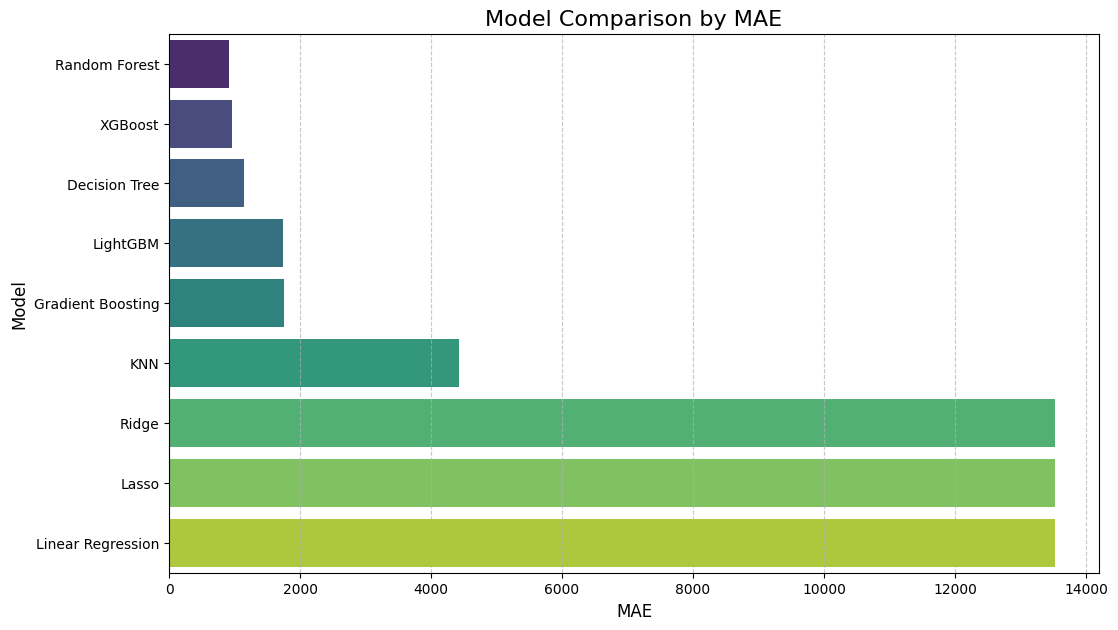

In [24]:
def plot_model_metrics(results, metric='r2'):
    """Creates a bar plot to compare model performance for a given metric."""
    # Sort models by the metric for better visualization
    sorted_models = sorted(results.items(), key=lambda item: item[1][metric], reverse=(metric=='r2'))
    names = [name for name, _ in sorted_models]
    values = [details[metric] for _, details in sorted_models]

    plt.figure(figsize=(12, 7))
    sns.barplot(x=values, y=names, palette='viridis')
    plt.title(f'Model Comparison by {metric.upper()}', fontsize=16)
    plt.xlabel(metric.upper(), fontsize=12)
    plt.ylabel('Model', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

# Generate plots for the key metrics
print("\nGenerating performance comparison plots...")
plot_model_metrics(results, metric='r2')
plot_model_metrics(results, metric='rmse')
plot_model_metrics(results, metric='mae')


In [25]:
# --- Save Best Model Config to YAML ---
import os
import yaml
model_config = {
    'model_details': {
        'name': 'delhi_house_rent_predictor',
        'best_model_name': best_model_name,
        'model_parameters': best_model_object.get_params(),
        'target_variable': 'price',
        'features_used': list(X.columns)
    },
    'performance_metrics': {
        'r2_score': float(best_model_details['r2']),
        'mean_absolute_error': float(best_model_details['mae']),
        'root_mean_squared_error': float(best_model_details['rmse'])
    }
}

config_path = '../configs/model_config.yaml'
os.makedirs(os.path.dirname(config_path), exist_ok=True)
with open(config_path, 'w') as f:
    yaml.dump(model_config, f, default_flow_style=False, sort_keys=False)

print(f"\n💾  Model config saved to '{config_path}'")


💾  Model config saved to '../configs/model_config.yaml'
